# Biblioteca

In [1]:
import pandas as pd
import sklearn
import numpy as np
import statsmodels 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style("whitegrid")
sns.set_palette("husl")

pd.set_option('display.max_rows', 200)

# Dados

In [3]:
features_selecionadas = ['ps_ind_01', 
                     'ps_ind_03', 
                     'ps_ind_07_bin', 
                     'ps_ind_08_bin', 
                     'ps_ind_15', 
                     'ps_ind_16_bin', 
                     'ps_ind_17_bin', 
                     'ps_reg_01', 
                     'ps_reg_02', 
                     'ps_car_11', 
                     'ps_car_15', 
                     'ps_calc_01', 
                     'ps_calc_02', 
                     'ps_calc_03', 
                     'ps_car_07_cat',
                     'ps_car_01_cat',
                     'ps_car_11_cat',
                     'ps_reg_03',
                     'ps_car_12',
                     'ps_car_13',
                     'ps_car_14',
                     ## reagrupadas
                     'ps_car_05_cat',
                     'ps_car_03_cat',
                     'ps_ind_04_cat',
                     'ps_ind_02_cat',
                     'ps_ind_05_cat',
                     'ps_car_04_cat',
                     'ps_car_09_cat']

In [4]:
# Removendo outliers e substituindo nulos pela média

def fix_nulls_and_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    v=1.5
    
    df_no_out = (df[["id", column]]
    .assign(**{column: lambda df: np.where(df[column] == -1, np.nan, df[column])}) ## corrigir nulos
    .assign(**{column+"_no_out": lambda df: np.where((df[column] > (Q3 + (v * IQR))), (Q3 + (v * IQR)), df[column])})
    .assign(**{column+"_no_out": lambda df: np.where((df[column] < (Q1 - (v * IQR))), (Q1 - (v * IQR)), df[column+"_no_out"])})
    .assign(**{column+"_no_out": lambda df: np.where(df[column+"_no_out"].isnull(), df[column+"_no_out"].mean(), df[column+"_no_out"])}) ## corrigir nulos
    .drop([column], 1))
    return df_no_out

In [6]:
# dados_raw = pd.read_csv("porto_seguro.csv")

remover_outliers_ps_reg_03 = fix_nulls_and_outliers(dados_raw, "ps_reg_03")
remover_outliers_ps_car_12 = fix_nulls_and_outliers(dados_raw, "ps_car_12")
remover_outliers_ps_car_13 = fix_nulls_and_outliers(dados_raw, "ps_car_13")
remover_outliers_ps_car_14 = fix_nulls_and_outliers(dados_raw, "ps_car_14")

dados = (
    dados_raw[["id", "target"] + features_selecionadas]
    ## tratando nulos em variável ordinal --> substituir pela moda
    .assign(ps_car_11 = lambda x: np.where(x.ps_car_11 == -1, x[x.ps_car_11 != -1].ps_car_11.mode(), x.ps_car_11))
    ## realizando agrupamento de variáveis categóricas e criando dummies
    ### ps_car_01_cat
    .assign(ps_car_01_cat_6_7 = lambda x: np.where(x.ps_car_01_cat.isin([6, 7]), 1, 0))
    .assign(ps_car_01_cat_3_4_5_10 = lambda x: np.where(x.ps_car_01_cat.isin([3, 4, 5, 10]), 1, 0))
    .assign(ps_car_01_cat_0_1_2_8_11 = lambda x: np.where(x.ps_car_01_cat.isin([0, 1, 2, 8, 11]), 1, 0))
    .assign(ps_car_01_cat_9 = lambda x: np.where(x.ps_car_01_cat == 9, 1, 0))
    .assign(ps_car_01_cat_null = lambda x: np.where(x.ps_car_01_cat == -1, 1, 0)) 
    ### ps_car_07_cat
    .assign(ps_car_07_cat_null = lambda x: np.where(x.ps_car_07_cat == -1, 1, 0))
    .assign(ps_car_07_cat_1 = lambda x: np.where(x.ps_car_07_cat == 1, 1, 0))
    ###  ps_car_11_cat
    .assign(ps_car_11_cat_A = lambda x: np.where(x.ps_car_11_cat.isin([43, 99, 57, 19, 32, 39, 7, 10, 16, 82, 66, 44, 67, 103, 95, 11, 9, 42, 64, 62, 88, 53, 37, 48, 84]), 1, 0))
    .assign(ps_car_11_cat_B = lambda x: np.where(x.ps_car_11_cat.isin([46, 14, 1, 47, 81, 25, 5, 28, 54, 35, 50, 45, 79, 20, 104, 90, 17, 89]), 1, 0))
    .assign(ps_car_11_cat_C = lambda x: np.where(x.ps_car_11_cat.isin([94, 13, 3, 69, 100, 61, 71, 33, 56, 55, 72, 21, 93, 97, 63, 4, 58, 75, 18, 41]), 1, 0))
    .assign(ps_car_11_cat_D = lambda x: np.where(x.ps_car_11_cat.isin([74, 30, 65, 98, 38, 60, 87, 85, 49, 96, 52, 22, 77, 86, 102, 26, 76, 40, 68, 15, 27, 73, 59, 29, 92, 34, 6, 51, 8, 70, 2, 101, 23, 31, 12, 78, 36, 24, 83, 80, 91] ), 1, 0))
    ### variáveis reagrupadas
    ### ps_car_05_cat
    .assign(ps_car_05_cat_0_1 = lambda x: np.where(x.ps_car_05_cat != -1, 1, 0))
    ### ps_car_03_cat
    .assign(ps_car_03_cat_1 = lambda x: np.where(x.ps_car_03_cat ==  1, 1, 0)) 
    ### ps_ind_04_cat
    .assign(ps_ind_04_cat_1 = lambda x: np.where(x.ps_ind_04_cat == 1, 1, 0))
    ### ps_ind_02_cat
    .assign(ps_ind_02_cat_1 = lambda x: np.where(x.ps_ind_02_cat == 1, 1, 0))
    ### ps_ind_05_cat
    .assign(ps_ind_05_cat_0 = lambda x: np.where(x.ps_ind_05_cat == 0, 1, 0))
    .assign(ps_ind_05_cat_1_3_4_5_6 = lambda x: np.where(x.ps_ind_05_cat.isin([1, 3, 4, 5, 6]), 1, 0)) 
    ### ps_car_04_cat
    .assign(ps_car_04_cat_0_1_2_4 = lambda x: np.where(x.ps_car_04_cat.isin([0, 1, 2, 4]), 1, 0))
    .assign(ps_car_04_cat_3_8 = lambda x: np.where(x.ps_car_04_cat.isin([3, 8]), 1, 0))
    ### ps_car_09_cat
    .assign(ps_car_09_cat_0_2_3 = lambda x: np.where(x.ps_car_09_cat.isin([0, 2, 3]), 1, 0))
    ## removendo outliers em variáveis contínuas e substituindo nulos pela média
    .merge(remover_outliers_ps_reg_03, on="id", how="left")
    .merge(remover_outliers_ps_car_12, on="id", how="left")
    .merge(remover_outliers_ps_car_13, on="id", how="left")
    .merge(remover_outliers_ps_car_14, on="id", how="left") 
    .drop(["ps_ind_02_cat", # variável modificada
           "ps_ind_05_cat", # variável modificada
           "ps_car_01_cat", # variável modificada
           "ps_car_04_cat", # variável modificada
           "ps_car_09_cat", # variável modificada
           "ps_car_11_cat", # variável modificada
           "ps_reg_03",     # variável modificada
           "ps_car_12",     # variável modificada
           "ps_car_13",     # variável modificada
           "ps_car_14",     # variável modificada
           "ps_ind_04_cat", # variável modificada
           "ps_car_03_cat", # variável modificada
           "ps_car_05_cat", # variável modificada
           "ps_car_07_cat", # variável modificada
           "ps_car_01_cat_null", # excluída por redundância 
           "ps_car_11_cat_D"     # excluída por redundância
          ], 1)
        )

In [7]:
from sklearn.model_selection import train_test_split

dados_treino, dados_teste = train_test_split(dados, random_state=37, test_size=0.3)

In [8]:
check = dados_raw.replace(-1, np.NaN)
total = check.isnull().sum().sort_values(ascending=False) 
percent = (check.isnull().sum()/check.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

# conferindo dados faltantes na base raw
missing_data.head(15)

,Total,Percent
ps_car_03_cat,411231,0.690898
ps_car_05_cat,266551,0.447825
ps_reg_03,107772,0.181065
ps_car_14,42620,0.071605
ps_car_07_cat,11489,0.019302
ps_ind_05_cat,5809,0.009760
ps_car_09_cat,569,0.000956
ps_ind_02_cat,216,0.000363
ps_car_01_cat,107,0.000180
ps_ind_04_cat,83,0.000139


In [9]:
check = dados.replace(-1, np.NaN)
total = check.isnull().sum().sort_values(ascending=False) 
percent = (check.isnull().sum()/check.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

# conferindo se há dados faltantes
missing_data.head()

,Total,Percent
ps_car_14_no_out,0,0.0
ps_reg_01,0,0.0
ps_car_01_cat_6_7,0,0.0
ps_calc_03,0,0.0
ps_calc_02,0,0.0


In [10]:
dados.drop(["id"], 1).describe().T

,count,mean,std,min,25%,50%,75%,max
target,595212.0,0.036448,0.187401,0.000000,0.000000,0.000000,0.000000,1.000000
ps_ind_01,595212.0,1.900378,1.983789,0.000000,0.000000,1.000000,3.000000,7.000000
ps_ind_03,595212.0,4.423318,2.699902,0.000000,2.000000,4.000000,6.000000,11.000000
ps_ind_07_bin,595212.0,0.257033,0.436998,0.000000,0.000000,0.000000,1.000000,1.000000
ps_ind_08_bin,595212.0,0.163921,0.370205,0.000000,0.000000,0.000000,0.000000,1.000000
ps_ind_15,595212.0,7.299922,3.546042,0.000000,5.000000,7.000000,10.000000,13.000000
ps_ind_16_bin,595212.0,0.660823,0.473430,0.000000,0.000000,1.000000,1.000000,1.000000
ps_ind_17_bin,595212.0,0.121081,0.326222,0.000000,0.000000,0.000000,0.000000,1.000000
ps_reg_01,595212.0,0.610991,0.287643,0.000000,0.400000,0.700000,0.900000,0.900000
ps_reg_02,595212.0,0.439184,0.404264,0.000000,0.200000,0.300000,0.600000,1.800000


In [11]:
dados.dtypes

id                            int64
target                        int64
ps_ind_01                     int64
ps_ind_03                     int64
ps_ind_07_bin                 int64
ps_ind_08_bin                 int64
ps_ind_15                     int64
ps_ind_16_bin                 int64
ps_ind_17_bin                 int64
ps_reg_01                   float64
ps_reg_02                   float64
ps_car_11                     int64
ps_car_15                   float64
ps_calc_01                  float64
ps_calc_02                  float64
ps_calc_03                  float64
ps_car_01_cat_6_7             int64
ps_car_01_cat_3_4_5_10        int64
ps_car_01_cat_0_1_2_8_11      int64
ps_car_01_cat_9               int64
ps_car_07_cat_null            int64
ps_car_07_cat_1               int64
ps_car_11_cat_A               int64
ps_car_11_cat_B               int64
ps_car_11_cat_C               int64
ps_car_05_cat_0_1             int64
ps_car_03_cat_1               int64
ps_ind_04_cat_1             

In [12]:
dados.groupby("target").id.nunique().reset_index()

,target,id
0,0,573518
1,1,21694


In [13]:
# dados_treino.to_csv('/Users/ninna.azevedo/Desktop/TCC/Porto Seguro/porto_seguro_stepwise_reagrupado_treino.csv', 
#               encoding = "utf-8", 
#               index=False)

# dados_teste.to_csv('/Users/ninna.azevedo/Desktop/TCC/Porto Seguro/porto_seguro_stepwise_reagrupado_teste.csv', 
#               encoding = "utf-8", 
#               index=False)

## Testando Regressão Logística

In [14]:
X = dados_treino.drop(["id", "target"], 1)
y = dados_treino.loc[:, ["target"]]

X_teste = dados_teste.drop(["id", "target"], 1)
y_teste = dados_teste.loc[:, ["target"]]

In [15]:
import statsmodels.formula.api as sm

model = sm.Logit(y, X)
result = model.fit()
predictions = result.predict(X_teste)

Optimization terminated successfully.
         Current function value: 0.153099
         Iterations 8


In [16]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               416648
Model:                          Logit   Df Residuals:                   416612
Method:                           MLE   Df Model:                           35
Date:                Sat, 11 May 2019   Pseudo R-squ.:                 0.02604
Time:                        02:22:39   Log-Likelihood:                -63789.
converged:                       True   LL-Null:                       -65494.
                                        LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ps_ind_01                    0.0122      0.004      2.724      0.006       0.003       0.021
ps_ind_03                    0.0256      0.003      7.570      0.000       0.019       0.

In [17]:
from sklearn.metrics import roc_auc_score

acc = roc_auc_score(y_teste, predictions)
print("AUC na base de teste: %.4f" % acc) 
### valor anterior: 0.6197 --> é um ganho considerável, dado que o auc do vencedor da competição foi de 0,64849

acc = roc_auc_score(y, result.predict(X))
print("AUC na base de treino: %.4f" % acc) 

AUC na base de teste: 0.6270
AUC na base de treino: 0.6306


# Variáveis Modificadas

Text(0.5,1,'Percentagem de sinistros por ps_car_09_cat')

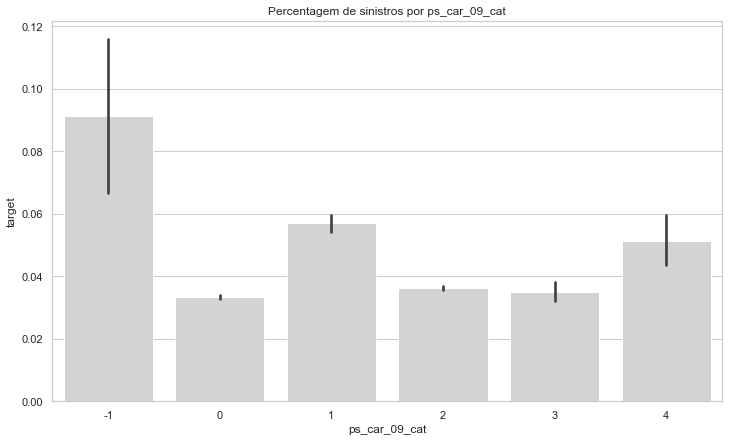

In [37]:
var = "ps_car_09_cat"

ax = sns.barplot(x=var, y="target", data=dados, color="lightgrey")
ax.set_title("Percentagem de sinistros por "+ var)

Text(0.5,1,'Percentagem de sinistros por ps_car_04_cat')

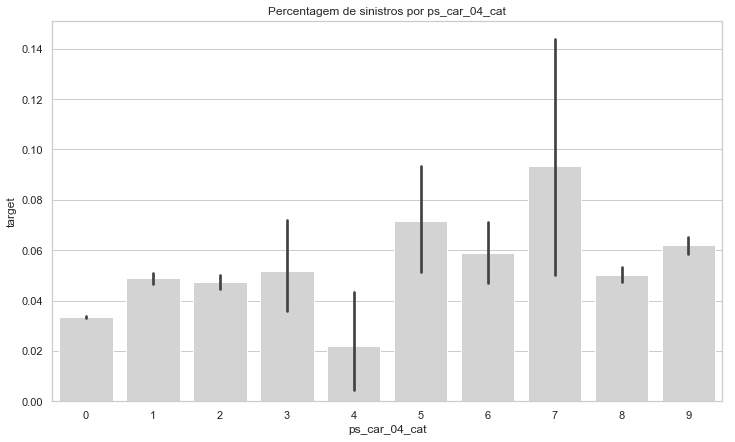

In [32]:
var = "ps_car_04_cat"

ax = sns.barplot(x=var, y="target", data=dados, color="lightgrey")
ax.set_title("Percentagem de sinistros por "+ var)

Text(0.5,1,'Percentagem de sinistros por ps_ind_05_cat')

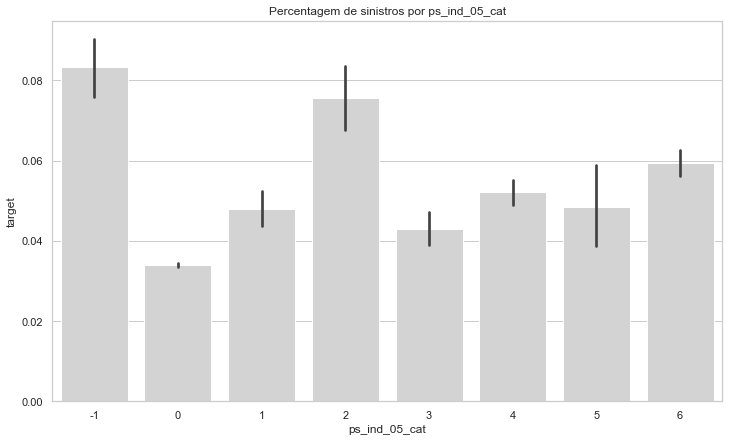

In [31]:
var = "ps_ind_05_cat"

ax = sns.barplot(x=var, y="target", data=dados, color="lightgrey")
ax.set_title("Percentagem de sinistros por "+ var)

Text(0.5,1,'Percentagem de sinistros por ps_ind_02_cat')

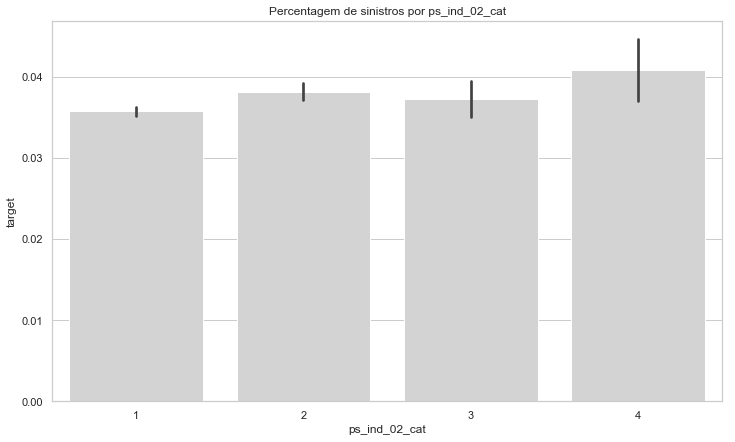

In [28]:
var = "ps_ind_02_cat"

ax = sns.barplot(x=var, y="target", data=dados.pipe(lambda x: x[x[var] >= 0]), color="lightgrey")
ax.set_title("Percentagem de sinistros por "+ var)

Text(0.5,1,'Percentagem de sinistros por ps_ind_04_cat')

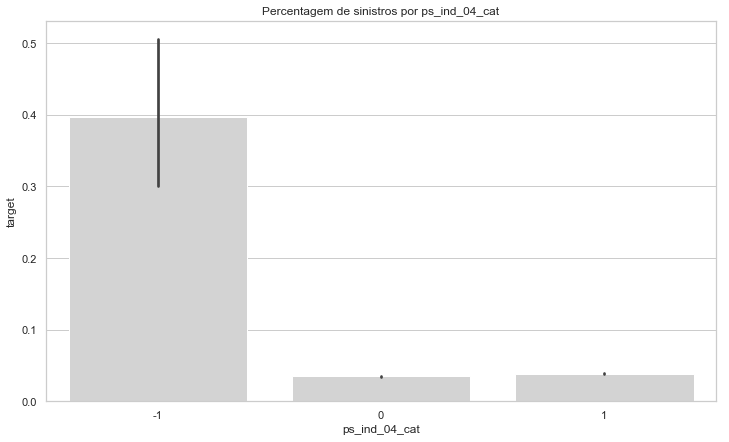

In [21]:
var = "ps_ind_04_cat"

ax = sns.barplot(x=var, y="target", data=dados, color="lightgrey")
ax.set_title("Percentagem de sinistros por "+ var)

Text(0.5,1,'Percentagem de sinistros por ps_car_03_cat')

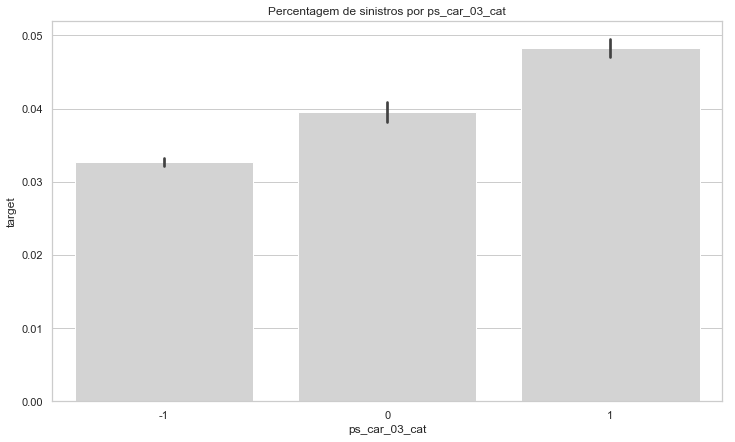

In [19]:
var = "ps_car_03_cat"

ax = sns.barplot(x=var, y="target", data=dados, color="lightgrey")
ax.set_title("Percentagem de sinistros por "+ var)

Text(0.5,1,'Percentagem de sinistros por ps_car_05_cat')

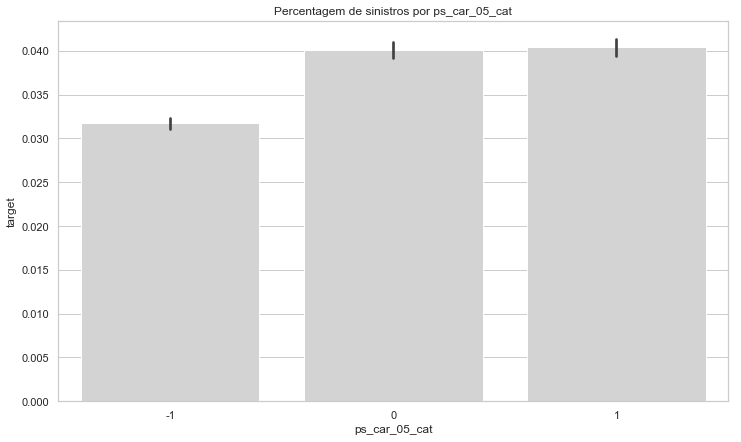

In [18]:
var = "ps_car_05_cat"

ax = sns.barplot(x=var, y="target", data=dados, color="lightgrey")
ax.set_title("Percentagem de sinistros por "+ var)

## Draft